In [201]:
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import datetime

Acquire SPEC benchmark data from the CSG API

In [202]:
urls = ['https://csgenome.org/api/benchmarks/spec1995?ontology=True&limit=10000', 'https://csgenome.org/api/benchmarks/spec2000?ontology=True&limit=10000', 'https://csgenome.org/api/benchmarks/spec2006?ontology=True&limit=10000', 'https://csgenome.org/api/benchmarks/spec2017?ontology=True&limit=10000']

benchmark_data = []
for url in urls:
  response = requests.get(url).json()
  benchmark_data.extend(response['data'])
  while response['links']['next'] is not None:
      url = response['links']['next']
      response = requests.get(url).json()
      benchmark_data.extend(response['data'])

In [ ]:
df = pd.json_normalize(benchmark_data)
df.head()

,date,memory_generation,ontology_uid,spec_uid
0,"Fri, 01 Jan 1999 05:00:00 GMT",SDR,4,1
1,"Fri, 01 Jan 1999 05:00:00 GMT",SDR,4,29
2,"Fri, 01 Jan 1999 05:00:00 GMT",SDR,4,19
3,"Fri, 01 Jan 1999 05:00:00 GMT",SDR,4,26
4,"Thu, 01 Apr 1999 05:00:00 GMT",SDR,4,362


Acquire memory ontology data from the CSG API

In [ ]:
ontology_url = 'https://csgenome.org/api/ontology_type?limit=10000'

response = requests.get(ontology_url).json()
ontology_data = response['data']
while response['links']['next'] is not None:
    ontology_url = response['links']['next']
    response = requests.get(ontology_url).json()
    ontology_data.extend(response['data'])

In [ ]:
df = pd.json_normalize(ontology_data)
df.head()

,bandwidth,cas_latency,cl_trcd_trp,clock_rate,cycle_time,dimm_pins,generation,memory_config,memory_type,microdimm_pins,module,other_type,sodimm_pins,standard,standard_type,transfer_rate,uid,voltage
0,533.0,None,N/A,66.0,15.0,None,SDR,[],SDRAM,None,PC-66,N/A,None,N/A,UNKNOWN,66.0,1,N/A
1,800.0,2.0,N/A,100.0,10.0,None,SDR,"[618, 619, 620, 628, 630, 666, 718, 719, 728, ...",SDRAM,None,PC-100,N/A,None,N/A,UNKNOWN,100.0,2,N/A
2,1066.0,3.0,N/A,133.0,7.5,None,SDR,"[672, 673, 1841, 1849, 1858, 1882, 1899, 2074,...",SDRAM,None,PC-133,N/A,None,N/A,UNKNOWN,133.0,3,N/A
3,None,None,N/A,None,None,None,SDR,"[609, 622, 631, 652, 661, 662, 669, 676, 677, ...",SDRAM,None,N/A,N/A,None,N/A,UNKNOWN,None,4,N/A
4,1600.0,None,N/A,100.0,10.0,184.0,DDR,"[1900, 1905, 1929, 1930, 1931, 1987, 1991, 201...",SDRAM,172.0,PC-1600,N/A,200.0,DDR-200,UNKNOWN,200.0,5,2.5


Function to generate data with specified memory attributes

In [ ]:
def generate_data(attr1, attr2=None):
  data = []

  for data_point_index in range(len(benchmark_data)):
    date_time_str = benchmark_data[data_point_index]['date'].split(', ')[1][:-4]
    date_time_obj = datetime.datetime.strptime(date_time_str, '%d %b %Y %I:%M:%S').date()

    ontology_index = benchmark_data[data_point_index]['ontology_uid']-1

    if attr2 is None:
      data.append((ontology_data[ontology_index][attr1], date_time_obj))
    else:
      data.append((ontology_data[ontology_index][attr1], ontology_data[ontology_index][attr2], date_time_obj))
    
  return data

Function to generate memory generation data lines on plots

In [ ]:
def generate_generation_lines(y, include_SDR=False):
  if include_SDR:
    generation_creation_dates = {
        'SDR': datetime.date(1993, 10, 1),
        'DDR': datetime.date(2000, 6, 1),
        'DDR2': datetime.date(2003, 4, 1),
        'DDR3': datetime.date(2007, 1, 1),
        'DDR4': datetime.date(2012, 10, 25)
    }
  else:
    generation_creation_dates = {
        'DDR': datetime.date(2000, 6, 1),
        'DDR2': datetime.date(2003, 4, 1),
        'DDR3': datetime.date(2007, 1, 1),
        'DDR4': datetime.date(2012, 10, 25)
    }

  for generation, creation_date in generation_creation_dates.items():
      plt.axvline(x=creation_date, color='black', ls='--', lw=2, label=generation)
      plt.text(creation_date + datetime.timedelta(30), y, generation, weight='bold', fontsize='x-large', verticalalignment='top',ha='left', rotation=0)

Memory Generation Over Time (Percentage of Market Share)

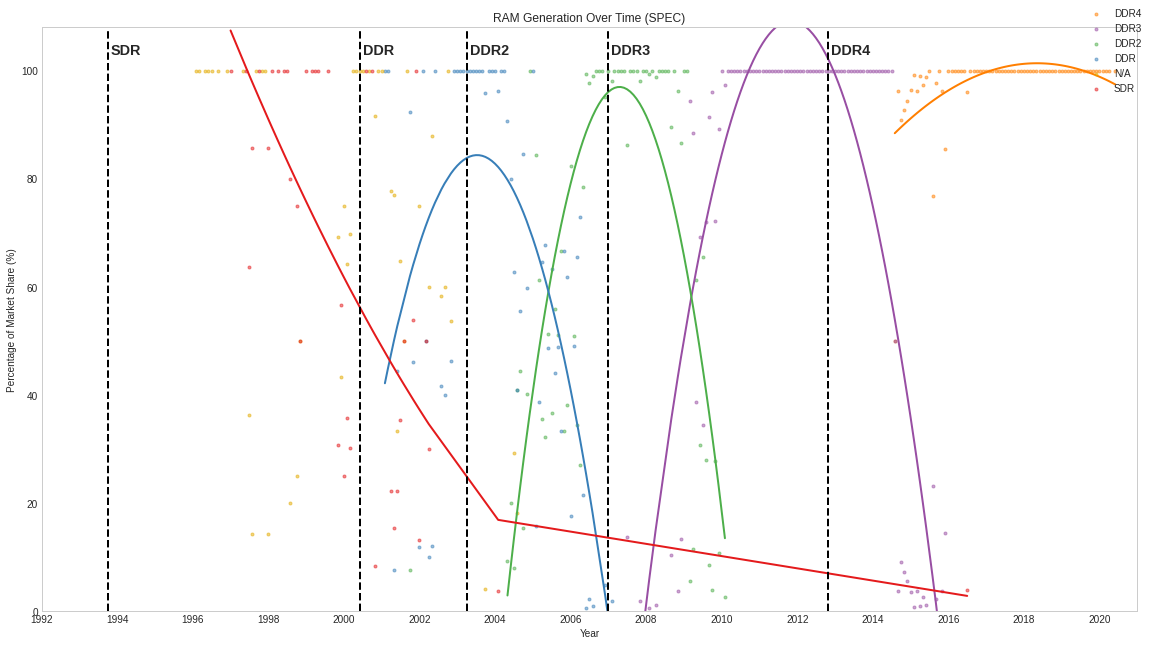

In [197]:
data = generate_data('generation')

generations = ['SDR', 'DDR', 'DDR2', 'DDR3', 'DDR4', 'N/A']
color_vals = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#e3aa00','#a65628']

generation_color_options = { k: v for k, v in zip(generations, color_vals)}

query_map = Counter(data)

query_counts = Counter(x[1] for x in data)

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

generation_data_points = defaultdict(list)

for k, v in query_map.most_common():
    generation_data_points[k[0]].append( { 'x': k[1], 'y':(100*v)/query_counts[k[1]] } )

for k in generation_data_points:
    generation_data_points[k] = sorted(generation_data_points[k], key=lambda x: x['x'])

beginning_date = datetime.date(1993, 10, 1)
for idx, (k, v) in enumerate(generation_data_points.items()):

    color = generation_color_options.get(k, 'black')
    x = [m['x'] for m in v]
    y = [m['y'] for m in v]
    ax.scatter(x, y, marker='.', c=color, label=k, alpha=0.5)

    v = list(filter(lambda o: o['x'] >= generation_creation_dates.get(k, datetime.date(1,1,1)) and o['x'] <= datetime.date(2022, 1, 1), v))
    filtered_y = np.array([m['y'] for m in v])
    x = np.array([m['x'] for m in v])
    normalized_x = np.array([ (m['x'] - beginning_date).days for m in v])
    if k == 'DDR4':
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    elif k == 'SDR':
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    else:
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    best_fit_func = np.poly1d(coefficients)
    best_fit_y = [best_fit_func(i) for i in normalized_x]
    if k != "N/A":
        ax.plot(x, best_fit_y, c=color, ls='-', lw=2)
ax.set_xlabel('Year')
    
ax.set_ylabel('Percentage of Market Share (%)')

plt.title('RAM Generation Over Time (SPEC)')
ax.set_xlim(datetime.date(1992, 1, 1), datetime.date(2021, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.legend() 

generate_generation_lines(105, True)

fig.tight_layout()
plt.ylim(0, 108)

plt.show()

Frequency Count of Memory Generation Over Time

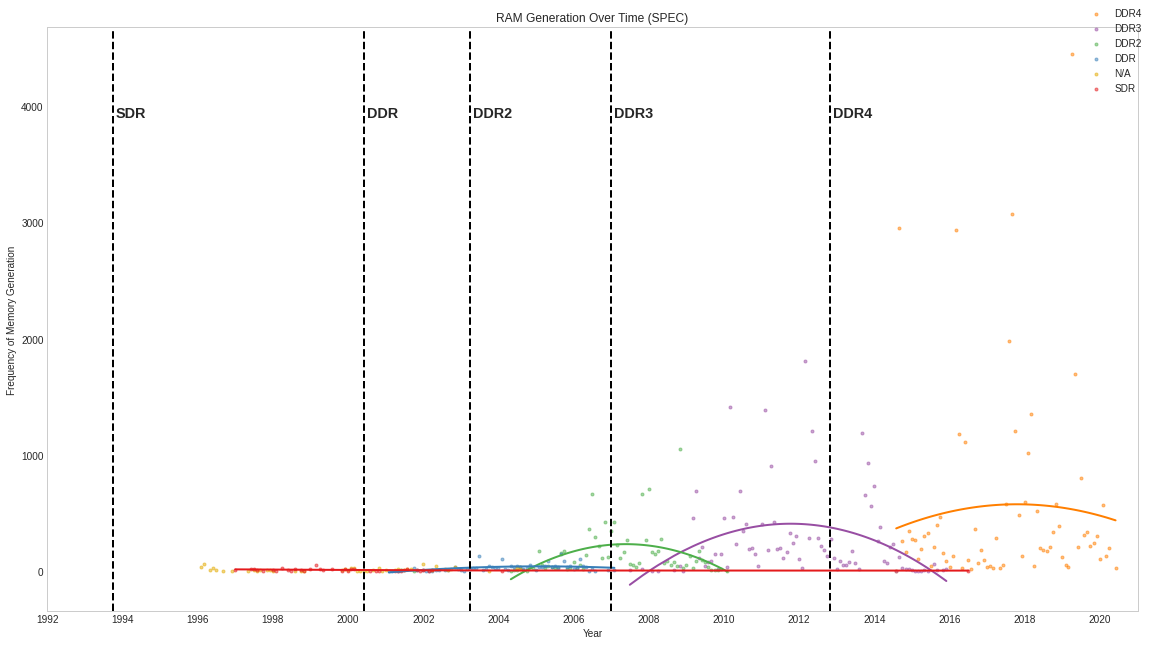

In [198]:
data = generate_data('generation')

generations = ['SDR', 'DDR', 'DDR2', 'DDR3', 'DDR4', 'N/A']
color_vals = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#e3aa00','#a65628']

generation_color_options = { k: v for k, v in zip(generations, color_vals)}

query_map = Counter(data)

query_counts = Counter(x[1] for x in data)

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

generation_data_points = defaultdict(list)

for k, v in query_map.most_common():
    generation_data_points[k[0]].append( { 'x': k[1], 'y':v } )

for k in generation_data_points:
    generation_data_points[k] = sorted(generation_data_points[k], key=lambda x: x['x'])

beginning_date = datetime.date(1993, 10, 1)
for idx, (k, v) in enumerate(generation_data_points.items()):

    color = generation_color_options.get(k, 'black')
    x = [m['x'] for m in v]
    y = [m['y'] for m in v]
    ax.scatter(x, y, marker='.', c=color, label=k, alpha=0.5)

    v = list(filter(lambda o: o['x'] >= generation_creation_dates.get(k, datetime.date(1,1,1)) and o['x'] <= datetime.date(2022, 1, 1), v))
    filtered_y = np.array([m['y'] for m in v])
    x = np.array([m['x'] for m in v])
    normalized_x = np.array([ (m['x'] - beginning_date).days for m in v])
    if k == 'DDR4':
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    elif k == 'SDR':
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    else:
        coefficients = np.polyfit(normalized_x, filtered_y, 2)
    best_fit_func = np.poly1d(coefficients)
    best_fit_y = [best_fit_func(i) for i in normalized_x]
    if k != "N/A":
        ax.plot(x, best_fit_y, c=color, ls='-', lw=2)
ax.set_xlabel('Year')
    
ax.set_ylabel('Frequency of Memory Generation')

plt.title('RAM Generation Over Time (SPEC)')
ax.set_xlim(datetime.date(1992, 1, 1), datetime.date(2021, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.legend()

generate_generation_lines(4000, True)

fig.tight_layout()

plt.show()

Frequency Count of Memory CAS Latency Over Time

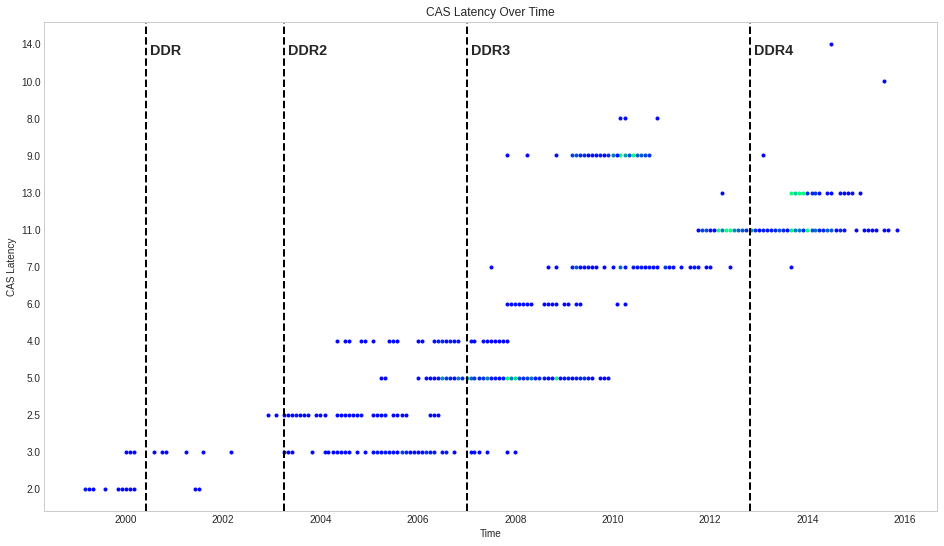

In [ ]:
data = generate_data('cas_latency')
data = [x for x in data if x[0]]

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

query_map = {}
for i in data:
    if(i[0]):
        if i in query_map:
            query_map[i] += 1
        else:
            query_map[i] = 1

key_max = max(query_map.keys(), key=(lambda k: query_map[k]))
key_min = min(query_map.keys(), key=(lambda k: query_map[k]))

norm = colors.Normalize(vmin=0, vmax=500)
cmap = plt.cm.winter

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.style.use('seaborn-whitegrid')
for k, v in query_map.items():
    plt.scatter(k[1], k[0], marker='.', c=[m.to_rgba(v)])

generate_generation_lines(12)

plt.xlabel('Time')
plt.ylabel('CAS Latency')
plt.title('CAS Latency Over Time')

plt.show()

Frequency Count of Memory Bandwidth Over Time

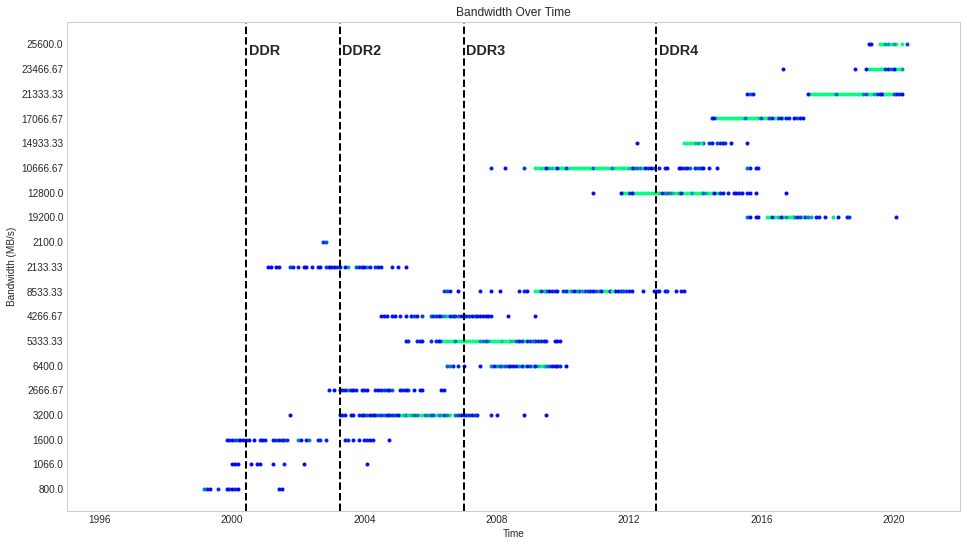

In [199]:
data = generate_data('bandwidth')
data = [x for x in data if x[0]]

query_map = {}
for i in data:
    if(i[0]):
        if i in query_map:
            query_map[i] += 1
        else:
            query_map[i] = 1

key_max = max(query_map.keys(), key=(lambda k: query_map[k]))
key_min = min(query_map.keys(), key=(lambda k: query_map[k]))

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

norm = colors.Normalize(vmin=0, vmax=100)
cmap = plt.cm.winter

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.style.use('seaborn-whitegrid')
for k, v in query_map.items():
    plt.scatter(k[1], k[0], marker='.', c=[m.to_rgba(v)])

generate_generation_lines(18)

plt.xlabel('Time')
plt.ylabel('Bandwidth (MB/s)')
plt.title('Bandwidth Over Time')
plt.xlim(datetime.date(1995, 1, 1), datetime.date(2021, 12, 31))

plt.show()

Comparison of Bandwidth and CAS Latency

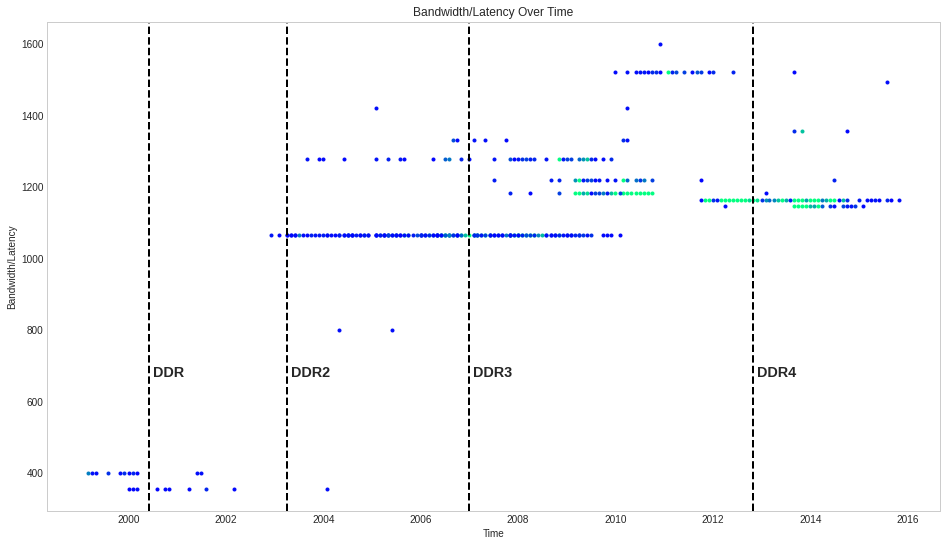

In [200]:
data = generate_data('bandwidth', 'cas_latency')
query_map = {}
for elem in data:
    if elem[0] is not None and elem[1] is not None:
        if elem in query_map:
            query_map[elem] += 1
        else:
            query_map[elem] = 1

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

key_max = max(query_map.keys(), key=(lambda k: query_map[k]))
key_min = min(query_map.keys(), key=(lambda k: query_map[k]))

norm = colors.Normalize(vmin=0, vmax=100)
cmap = plt.cm.winter

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.style.use('seaborn-whitegrid')

for k, v in query_map.items():
    plt.scatter(k[2], float(k[0])/float(k[1]), marker='.', c=[m.to_rgba(v)])

generate_generation_lines(700)

plt.xlabel('Time')
plt.ylabel('Bandwidth/Latency')
plt.title('Bandwidth/Latency Over Time')

plt.show()

Frequency Count of Cycle Time Over Time

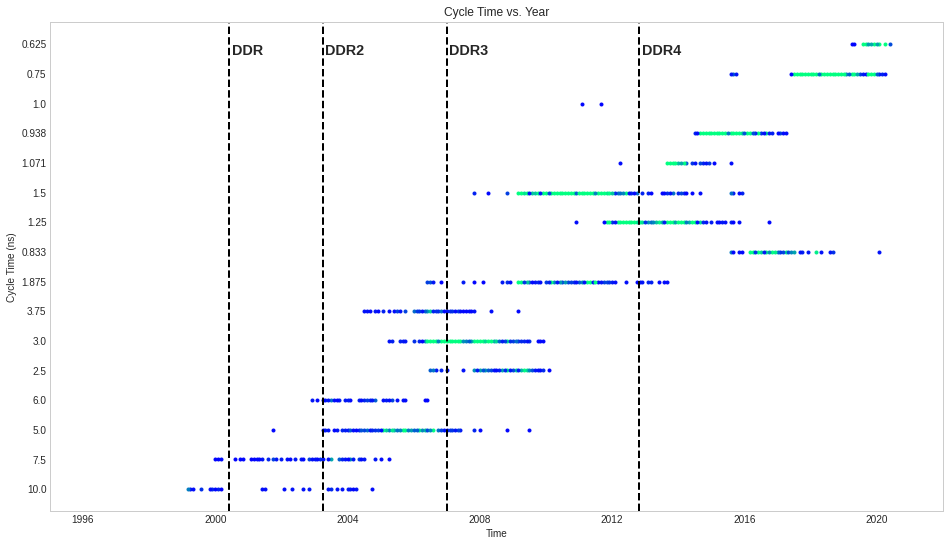

In [188]:
data = generate_data('cycle_time')

query_map = {}
for i in data:
    if(i[0]):
        if i in query_map:
            query_map[i] += 1
        else:
            query_map[i] = 1

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

key_max = max(query_map.keys(), key=(lambda k: query_map[k]))
key_min = min(query_map.keys(), key=(lambda k: query_map[k]))

norm = colors.Normalize(vmin=0, vmax=100)
cmap = plt.cm.winter

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.style.use('seaborn-whitegrid')
for k, v in query_map.items():
    plt.scatter(k[1], k[0], marker='.', c=[m.to_rgba(v)])

generate_generation_lines(15)

plt.xlim(datetime.date(1995, 1, 1), datetime.date(2021, 12, 31))

plt.xlabel('Time')
plt.ylabel('Cycle Time (ns)')
plt.title('Cycle Time vs. Year')

plt.show()

Frequency Count of Memory Latency Over Time

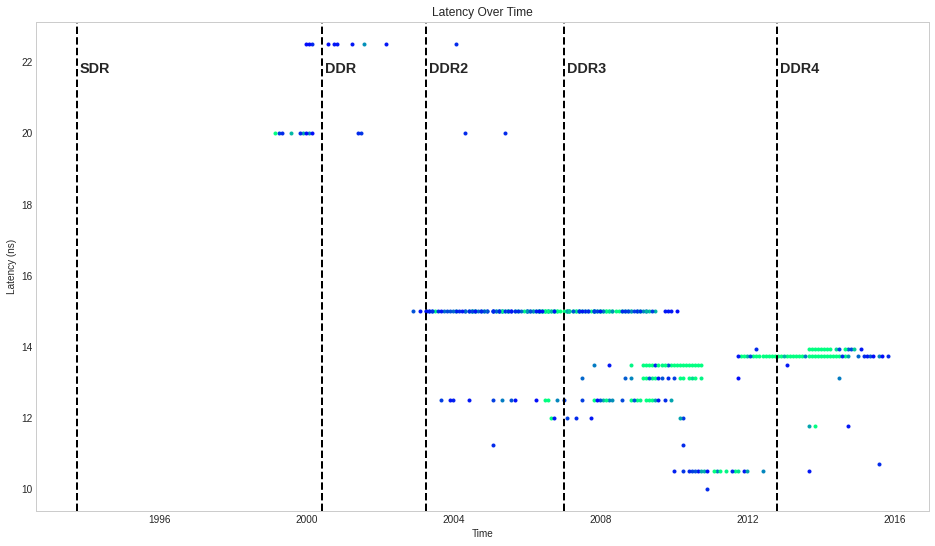

In [196]:
data = generate_data('cycle_time', 'cas_latency')

query_map = {}
for elem in data:
    if elem[0] is not None and elem[1] is not None and elem[2] is not None:
        if elem in query_map:
            query_map[elem] += 1
        else:
            query_map[elem] = 1
    norm = colors.Normalize(vmin=0, vmax=25)
    cmap = plt.cm.winter

fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.grid()

m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.style.use('seaborn-whitegrid')
for k, v in query_map.items():
    plt.scatter(k[2], float(k[0]) * float(k[1]), marker='.', c=[m.to_rgba(v)])

generate_generation_lines(22, True)

plt.xlabel('Time')
plt.ylabel('Latency (ns)')
plt.title('Latency Over Time')

plt.show()